In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

# Variable filter length 

---

This notebook show how to apply variable filter scales with implicit filter. This example is shown for ICON, however the procedure it's the same for all filter types.

In [3]:
from implicit_filter import IconFilter

filter = IconFilter()
filter.prepare_from_file("/scratch/b/b382615/filters/implicit_filter_ICON_grid2d_test.nc", gpu=True)

In [4]:
filter.save_to_file("../icon_cash")

In [12]:
filter.set_backend("gpu")

In [5]:
filter = IconFilter.load_from_file("../icon_cash.npz")

In [5]:
import xarray as xr

data = xr.open_dataset("/scratch/b/b382615/filters/implicit_filter_ICON_test.nc")

ux = data['u'].values[0, :]
vy = data['v'].values[0, :]

In [6]:
grid2d = xr.open_dataset("/scratch/b/b382615/filters/implicit_filter_ICON_grid2d_test.nc")
xcoord = grid2d["vlon"].values * 180.0 / np.pi
ycoord = grid2d["vlat"].values * 180.0 / np.pi
tri = grid2d["vertex_of_cell"].values.T.astype(int) - 1

In [12]:
mask = grid2d["cell_sea_land_mask"].values * -1
mask[mask == 2] = 1
mask[mask == -2] = -1
mask = mask.astype(np.bool)

In [7]:
from implicit_filter import transform_velocity_to_nodes

uxn, vyn = transform_velocity_to_nodes(ux, vy, filter) # This function based on the mesh will interpolate velocity to nodes

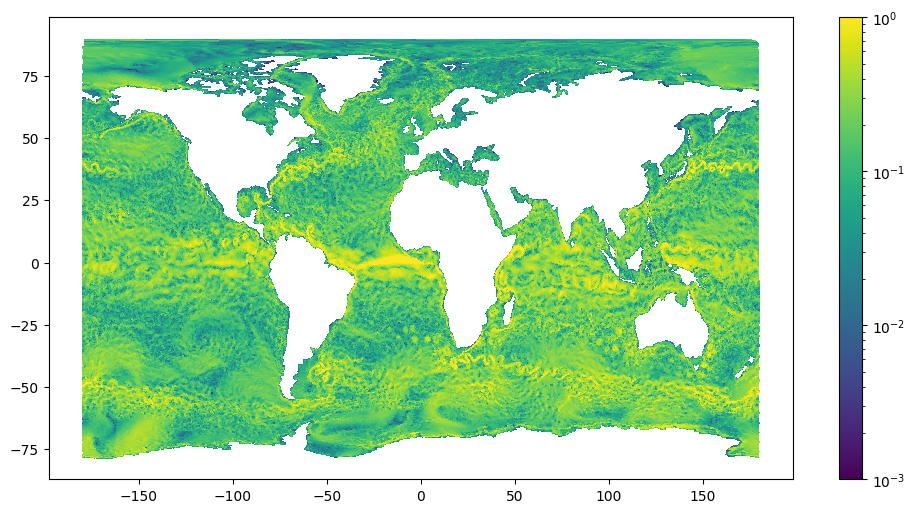

In [10]:
ok =(xcoord[tri].max(axis=1)-xcoord[tri].min(axis=1))<10 
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri[ok, :])

plt.tripcolor(triang, np.sqrt(np.square(uxn) + np.square(vyn)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-0))
plt.colorbar()

### Prepare scales for filtering

One has to compute scale individually for each mesh node. 

In [13]:
var_scale =  300 * np.abs(np.deg2rad(ycoord)) + 150.

In [14]:
var_scale

array([527.81583914, 527.81583914, 527.52754355, ..., 386.64948274,
       386.32437588, 386.63702895], shape=(7487687,))

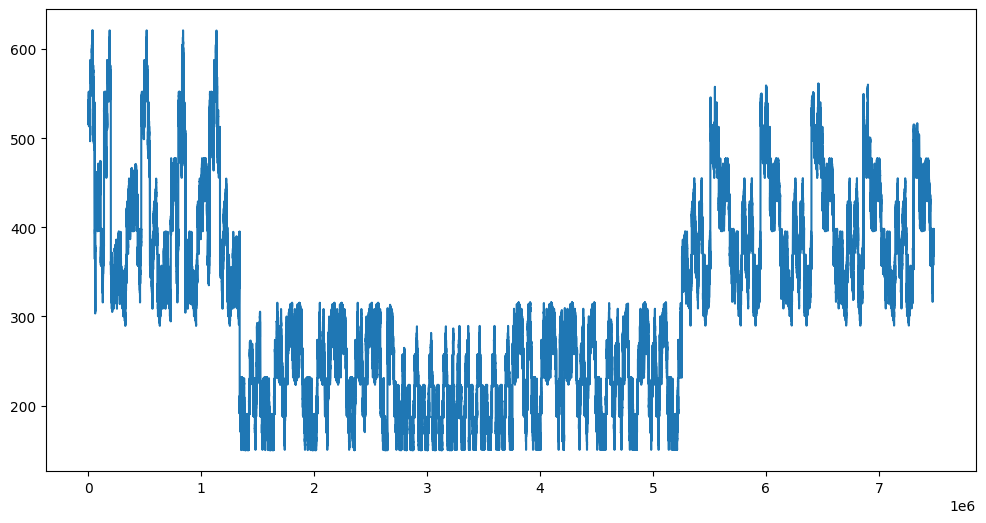

In [15]:
plt.plot(var_scale)

In [16]:
ttu, ttv = filter.compute_velocity(1, 2 * math.pi / var_scale, uxn, vyn)

In [9]:
np.sum(ttu - uxn)

np.float64(-452.8639378583862)

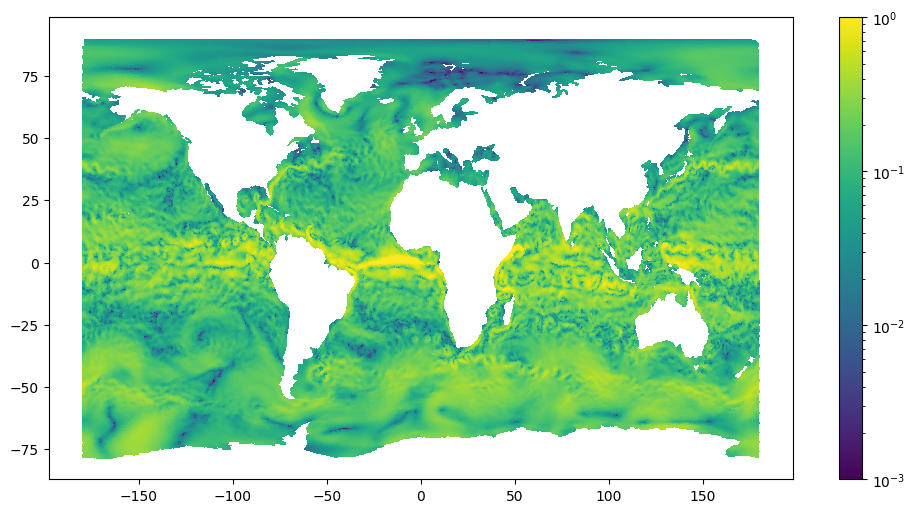

In [17]:
plt.tripcolor(triang, np.sqrt(np.square(ttu) + np.square(ttv)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-0))
plt.colorbar()

In [2]:
from implicit_filter import NemoFilter, transform_to_T_cells
import xarray as xr

### NEMO mesh file path

In [3]:
mesh_file = "../data/mesh_mask.nc"

In [4]:
filter = NemoFilter()
filter.prepare_from_file(file=mesh_file, vl=0)

# Load NEMO data

---

Remember
to
exclude
redundant
data
at
the
borders

In [5]:
s = xr.open_dataset("../data/FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_U.nc")
ux = s.vozocrtx.isel(time_counter=0, depthu=0, y=slice(None, -2), x=slice(None, -2)).transpose("x", "y").values
s = xr.open_dataset("../data/FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_V.nc")
vy = s.vomecrty.isel(time_counter=0, depthv=0, y=slice(None, -2), x=slice(None, -2)).transpose("x", "y").values

uxn, vyn = transform_to_T_cells(ux, vy, filter)

In [6]:
ycoord = s.nav_lat.isel(
    y=slice(None, -2),
    x=slice(None, -2),
).squeeze().transpose("x", "y").values.flatten()

In [7]:
var_scale = 300 * np.abs(np.deg2rad(ycoord)) + 150.

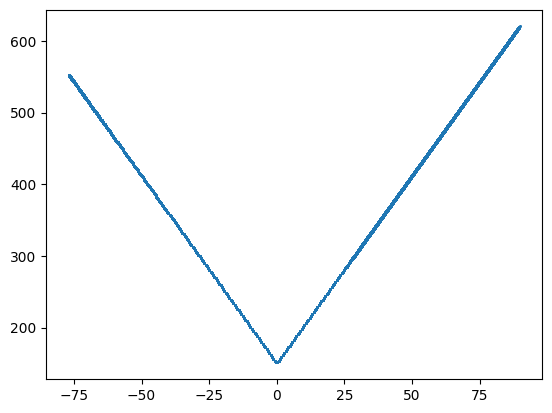

In [8]:
plt.scatter(ycoord, var_scale, s=1)

In [9]:
ttu, ttv = filter.compute_velocity(1, 2 * math.pi / 100., uxn, vyn)

KeyboardInterrupt: 

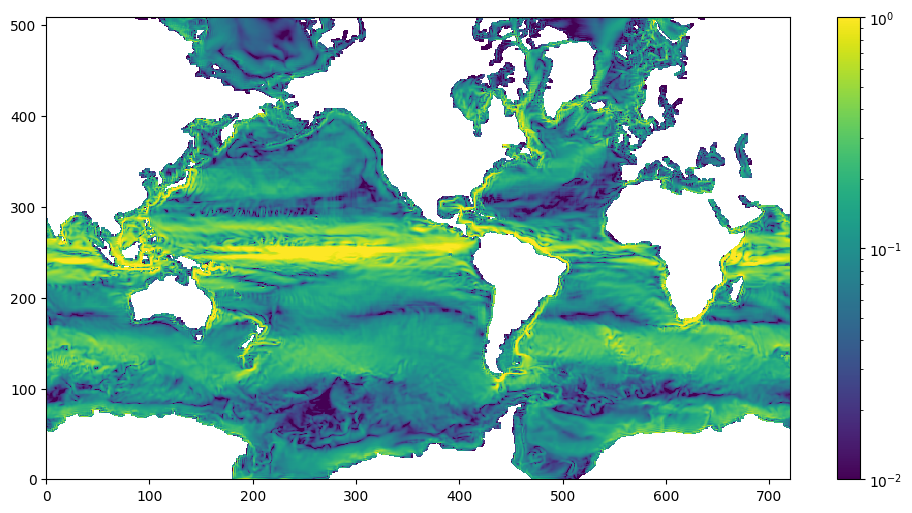

In [14]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.pcolor(np.sqrt(np.square(uxn) + np.square(vyn)).T, norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e-0))
plt.figsize=(80, 40)
plt.colorbar()

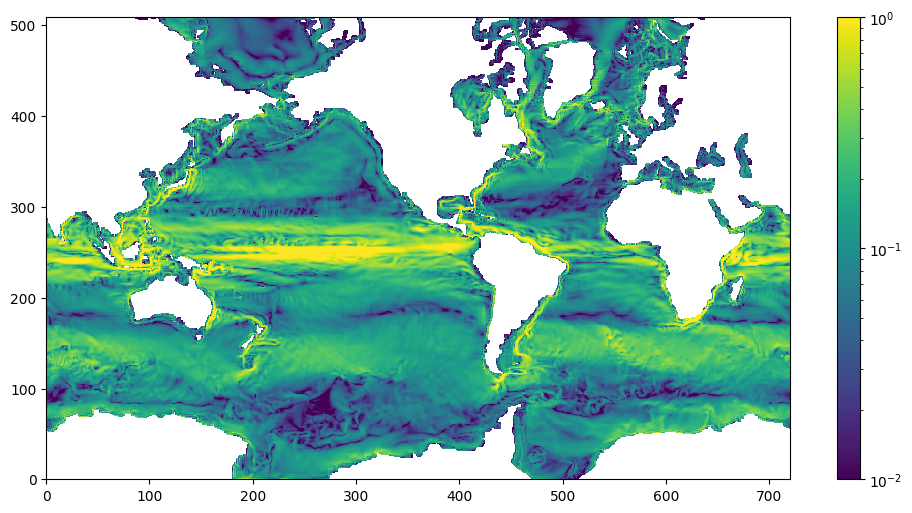

In [15]:
plt.pcolor(np.sqrt(np.square(ttu) + np.square(ttv)).T, norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e-0))
plt.figsize=(80, 40)
plt.colorbar()

In [16]:
np.sum(ttu - uxn)

np.float64(-0.0007843855282433643)